# Preprocessing

In [1]:
import numpy as np
import pandas as pd

from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import keras.backend as K

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

C:\Users\cosin\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def readFile(filepath, X):
    with open(filepath) as file:
        array = [line.strip() for line in file]
    full_size = int(array[0].split(' ')[0])
    features = int(array[0].split(' ')[1])
    classes = int(array[0].split(' ')[2])
    sample_size = 0
    for i in range(min(full_size*2, 2000)):
        s = array[i].split(' ')
        if len(s) > 10:
            sample_size += 1
            X.append(s)
    return sample_size, features, classes

In [3]:
def readFullFile(filepath, X):
    with open(filepath) as file:
        array = [line.strip() for line in file]
    full_size = int(array[0].split(' ')[0])
    features = int(array[0].split(' ')[1])
    classes = int(array[0].split(' ')[2])
    sample_size = 0
    for i in range(full_size*2):
        s = array[i].split(' ')
        if len(s) > 10:
            sample_size += 1
            X.append(s)
    return sample_size, features, classes

In [4]:
X_4 = [] # Навальный
X_5 = [] # Путин

In [5]:
size_4, features, _ = readFile('trainFull/train4.data', X_4)
size_4

1000

In [6]:
size_5, _, features = readFile('trainFull/train5.data', X_5)
size_5

1000

In [7]:
X_4 = np.array(X_4).astype(float)
X_5 = np.array(X_5).astype(float)
X_4 = (X_4+1)/2
X_5 = (X_5+1)/2

In [8]:
y_4 = np.zeros(1000)
y_5 = np.ones(1000)

In [9]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [10]:
X = np.vstack((X_4, X_5))
y = np.append(y_4, y_5)
X.shape

(2000, 7282)

In [11]:
X_4_full = [] # Навальный
X_5_full = [] # Путин

In [12]:
size_4, _, _ = readFullFile('trainFull/train4.data', X_4_full)
size_4

1998

In [13]:
size_5, _, _ = readFullFile('trainFull/train5.data', X_5_full)
size_5

5000

In [14]:
X_4_full = np.array(X_4_full).astype(float)
X_5_full = np.array(X_5_full).astype(float)
X_4_full = (X_4_full+1)/2
X_5_full = (X_5_full+1)/2

In [20]:
X_full = np.vstack((X_4_full, X_5_full))
y_full = np.append(np.zeros(X_4_full.shape[0]), np.ones(X_5_full.shape[0]))
X_full.shape

(6998, 7282)

# PCA

Text(0,0.5,'Cumulative explained variance')

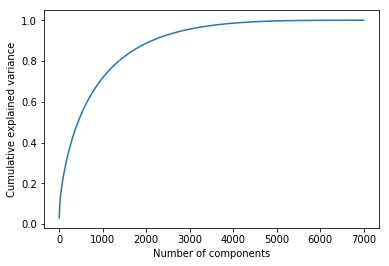

In [36]:
pca = PCA(n_components=7000)
pca.fit(X_full)

plot(np.cumsum(pca.explained_variance_ratio_))
xlabel('Number of components')
ylabel('Cumulative explained variance')

In [30]:
pca.components_.shape

(2000, 7282)

# NN

In [41]:
batch_size = 100
epochs = 80
dropout_size = 0.5
n = 10

nav_rec = []
put_rec = []

for i in np.arange(500, 600, 100):
    X = np.vstack((X_4_full[0:1800, :], X_5_full[0:1800, :]))
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_4_full_pca = pca.transform(X_4_full[1800:, :])
    X_5_full_pca = pca.transform(X_5_full[1800:, :])
    y = np.append(np.zeros(1800), np.ones(1800))
    
    nav = []
    put = []
    for train, test in kfold.split(X_pca, y):
        model = Sequential()
        model.add(Dense(250, input_dim=n, activation='relu'))
        Dropout(dropout_size)
        model.add(Dense(100, activation='relu'))
        Dropout(dropout_size/2)
        model.add(Dense(40, activation='relu'))
        Dropout(dropout_size/3)
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

        model.fit(X_pca[train], y[train], batch_size=batch_size, epochs=epochs, shuffle=True,
                    validation_data=(X_pca[test], y[test]))
        nav_scores = model.evaluate(X_4_full_pca, np.zeros(X_4_full_pca.shape[0]))
        put_scores = model.evaluate(X_5_full_pca, np.ones(X_5_full_pca.shape[0]))
        nav.append(round(nav_scores[1] * 100, 2))
        put.append(round(put_scores[1] * 100, 2))
    nav.append(n)
    nav.append(i)
    put.append(n)
    put.append(i)
    nav_rec.append(nav)
    put_rec.append(put)

Train on 2400 samples, validate on 1200 samples
Epoch 1/80
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6940 - acc: 0.4608 - val_loss: 0.6902 - val_acc: 0.5300
Epoch 2/80
2400/2400 [==============================] - 0s 70us/step - loss: 0.6872 - acc: 0.5888 - val_loss: 0.6837 - val_acc: 0.6475
Epoch 3/80
2400/2400 [==============================] - 0s 68us/step - loss: 0.6811 - acc: 0.6812 - val_loss: 0.6776 - val_acc: 0.7300
Epoch 4/80
2400/2400 [==============================] - 0s 107us/step - loss: 0.6752 - acc: 0.7288 - val_loss: 0.6716 - val_acc: 0.7608
Epoch 5/80
2400/2400 [==============================] - 0s 98us/step - loss: 0.6694 - acc: 0.7508 - val_loss: 0.6655 - val_acc: 0.7642
Epoch 6/80
2400/2400 [==============================] - 0s 108us/step - loss: 0.6634 - acc: 0.7608 - val_loss: 0.6592 - val_acc: 0.7750
Epoch 7/80
2400/2400 [==============================] - 0s 101us/step - loss: 0.6571 - acc: 0.7700 - val_loss: 0.6523 - val_acc: 0.7792
Epoch

Epoch 61/80
2400/2400 [==============================] - 0s 66us/step - loss: 0.4077 - acc: 0.8175 - val_loss: 0.4068 - val_acc: 0.8183
Epoch 62/80
2400/2400 [==============================] - 0s 65us/step - loss: 0.4069 - acc: 0.8200 - val_loss: 0.4062 - val_acc: 0.8200
Epoch 63/80
2400/2400 [==============================] - 0s 66us/step - loss: 0.4058 - acc: 0.8187 - val_loss: 0.4054 - val_acc: 0.8225
Epoch 64/80
2400/2400 [==============================] - 0s 65us/step - loss: 0.4049 - acc: 0.8192 - val_loss: 0.4049 - val_acc: 0.8217
Epoch 65/80
2400/2400 [==============================] - 0s 69us/step - loss: 0.4039 - acc: 0.8183 - val_loss: 0.4043 - val_acc: 0.8225
Epoch 66/80
2400/2400 [==============================] - 0s 67us/step - loss: 0.4030 - acc: 0.8175 - val_loss: 0.4039 - val_acc: 0.8208
Epoch 67/80
2400/2400 [==============================] - 0s 87us/step - loss: 0.4022 - acc: 0.8200 - val_loss: 0.4034 - val_acc: 0.8208
Epoch 68/80
2400/2400 [=========================

Epoch 40/80
2400/2400 [==============================] - 0s 51us/step - loss: 0.4313 - acc: 0.8087 - val_loss: 0.4269 - val_acc: 0.8133
Epoch 41/80
2400/2400 [==============================] - 0s 53us/step - loss: 0.4290 - acc: 0.8083 - val_loss: 0.4251 - val_acc: 0.8142
Epoch 42/80
2400/2400 [==============================] - 0s 55us/step - loss: 0.4272 - acc: 0.8121 - val_loss: 0.4230 - val_acc: 0.8150
Epoch 43/80
2400/2400 [==============================] - 0s 54us/step - loss: 0.4252 - acc: 0.8121 - val_loss: 0.4213 - val_acc: 0.8150
Epoch 44/80
2400/2400 [==============================] - 0s 51us/step - loss: 0.4235 - acc: 0.8121 - val_loss: 0.4196 - val_acc: 0.8183
Epoch 45/80
2400/2400 [==============================] - 0s 56us/step - loss: 0.4217 - acc: 0.8125 - val_loss: 0.4181 - val_acc: 0.8175
Epoch 46/80
2400/2400 [==============================] - 0s 51us/step - loss: 0.4201 - acc: 0.8142 - val_loss: 0.4166 - val_acc: 0.8175
Epoch 47/80
2400/2400 [=========================

Epoch 19/80
2400/2400 [==============================] - 0s 52us/step - loss: 0.5221 - acc: 0.7796 - val_loss: 0.5287 - val_acc: 0.7775
Epoch 20/80
2400/2400 [==============================] - 0s 55us/step - loss: 0.5138 - acc: 0.7829 - val_loss: 0.5216 - val_acc: 0.7775
Epoch 21/80
2400/2400 [==============================] - 0s 61us/step - loss: 0.5060 - acc: 0.7825 - val_loss: 0.5149 - val_acc: 0.7808
Epoch 22/80
2400/2400 [==============================] - 0s 56us/step - loss: 0.4987 - acc: 0.7854 - val_loss: 0.5087 - val_acc: 0.7825
Epoch 23/80
2400/2400 [==============================] - 0s 57us/step - loss: 0.4918 - acc: 0.7850 - val_loss: 0.5028 - val_acc: 0.7808
Epoch 24/80
2400/2400 [==============================] - 0s 51us/step - loss: 0.4852 - acc: 0.7858 - val_loss: 0.4974 - val_acc: 0.7842
Epoch 25/80
2400/2400 [==============================] - 0s 58us/step - loss: 0.4791 - acc: 0.7875 - val_loss: 0.4923 - val_acc: 0.7858
Epoch 26/80
2400/2400 [=========================

In [42]:
nav_rec

[[81.310000000000002, 82.829999999999998, 80.299999999999997, 10, 500]]

In [43]:
put_rec

[[93.120000000000005, 93.159999999999997, 93.879999999999995, 10, 500]]

In [17]:
n = 10

batch_size = 100
epochs = 80
dropout_size = 0.5

pca = PCA(n_components=n)
pca.fit(X)
X_pca = pca.transform(X)
X_4_full_pca = pca.transform(X_4_full[1000:, :])
X_5_full_pca = pca.transform(X_5_full[1000:, :])
    
nav = []
put = []
for train, test in kfold.split(X_pca, y):
    model = Sequential()
    model.add(Dense(250, input_dim=n, activation='relu'))
    Dropout(dropout_size)
    model.add(Dense(100, activation='relu'))
    Dropout(dropout_size/2)
    model.add(Dense(40, activation='relu'))
    Dropout(dropout_size/3)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    model.fit(X_pca[train], y[train], batch_size=batch_size, epochs=epochs, shuffle=True, 
              validation_data=(X_pca[test], y[test]))
    nav_scores = model.evaluate(X_4_full_pca, np.zeros(X_4_full_pca.shape[0]))
    put_scores = model.evaluate(X_5_full_pca, np.ones(X_5_full_pca.shape[0]))
    nav.append(round(nav_scores[1] * 100, 2))
    put.append(round(put_scores[1] * 100, 2))

Train on 1332 samples, validate on 668 samples
Epoch 1/80
1332/1332 [==============================] - 15s 11ms/step - loss: 0.6824 - acc: 0.5893 - val_loss: 0.6791 - val_acc: 0.6213
Epoch 2/80
1332/1332 [==============================] - 0s 68us/step - loss: 0.6757 - acc: 0.6216 - val_loss: 0.6721 - val_acc: 0.6527
Epoch 3/80
1332/1332 [==============================] - 0s 64us/step - loss: 0.6693 - acc: 0.6607 - val_loss: 0.6655 - val_acc: 0.6826
Epoch 4/80
1332/1332 [==============================] - 0s 67us/step - loss: 0.6631 - acc: 0.6839 - val_loss: 0.6587 - val_acc: 0.7081
Epoch 5/80
1332/1332 [==============================] - 0s 64us/step - loss: 0.6566 - acc: 0.7020 - val_loss: 0.6520 - val_acc: 0.7260
Epoch 6/80
1332/1332 [==============================] - 0s 64us/step - loss: 0.6503 - acc: 0.7230 - val_loss: 0.6454 - val_acc: 0.7380
Epoch 7/80
1332/1332 [==============================] - 0s 71us/step - loss: 0.6440 - acc: 0.7335 - val_loss: 0.6388 - val_acc: 0.7455
Epoch 8

Epoch 39/80
1334/1334 [==============================] - 0s 58us/step - loss: 0.4779 - acc: 0.8163 - val_loss: 0.4940 - val_acc: 0.8048
Epoch 40/80
1334/1334 [==============================] - 0s 97us/step - loss: 0.4724 - acc: 0.8171 - val_loss: 0.4888 - val_acc: 0.8048
Epoch 41/80
1334/1334 [==============================] - 0s 85us/step - loss: 0.4672 - acc: 0.8178 - val_loss: 0.4836 - val_acc: 0.8048
Epoch 42/80
1334/1334 [==============================] - 0s 77us/step - loss: 0.4620 - acc: 0.8193 - val_loss: 0.4786 - val_acc: 0.8048
Epoch 43/80
1334/1334 [==============================] - 0s 82us/step - loss: 0.4569 - acc: 0.8186 - val_loss: 0.4738 - val_acc: 0.8048
Epoch 44/80
1334/1334 [==============================] - 0s 80us/step - loss: 0.4521 - acc: 0.8186 - val_loss: 0.4690 - val_acc: 0.8063
Epoch 45/80
1334/1334 [==============================] - 0s 70us/step - loss: 0.4475 - acc: 0.8223 - val_loss: 0.4643 - val_acc: 0.8063
Epoch 46/80
1334/1334 [=========================

1334/1334 [==============================] - 0s 80us/step - loss: 0.5970 - acc: 0.8133 - val_loss: 0.5897 - val_acc: 0.8123
Epoch 19/80
1334/1334 [==============================] - 0s 88us/step - loss: 0.5908 - acc: 0.8141 - val_loss: 0.5833 - val_acc: 0.8153
Epoch 20/80
1334/1334 [==============================] - 0s 79us/step - loss: 0.5845 - acc: 0.8111 - val_loss: 0.5770 - val_acc: 0.8168
Epoch 21/80
1334/1334 [==============================] - 0s 94us/step - loss: 0.5782 - acc: 0.8126 - val_loss: 0.5707 - val_acc: 0.8183
Epoch 22/80
1334/1334 [==============================] - 0s 95us/step - loss: 0.5719 - acc: 0.8111 - val_loss: 0.5642 - val_acc: 0.8213
Epoch 23/80
1334/1334 [==============================] - 0s 79us/step - loss: 0.5656 - acc: 0.8096 - val_loss: 0.5576 - val_acc: 0.8198
Epoch 24/80
1334/1334 [==============================] - 0s 85us/step - loss: 0.5590 - acc: 0.8096 - val_loss: 0.5510 - val_acc: 0.8183
Epoch 25/80
1334/1334 [==============================] - 0s 

# SKLearn

In [32]:
n = 10

X = np.vstack((X_4_full[0:1800, :], X_5_full[0:1800, :]))
pca = PCA(n_components=n)
pca.fit(X)
X_pca = pca.transform(X)
X_4_full_pca = pca.transform(X_4_full[1800:, :])
X_5_full_pca = pca.transform(X_5_full[1800:, :])
y = np.append(np.zeros(1800), np.ones(1800))
y_4 = np.zeros(X_4_full_pca.shape[0])
y_5 = np.ones(X_5_full_pca.shape[0])

In [18]:
from sklearn.ensemble import RandomForestClassifier as rfc
from xgboost import XGBClassifier as xgb
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB

## SGD

In [33]:
nav = []
put = []

param_grid = {'alpha' : [0.0001 ,0.001, 0.1, 1, 10]}
scores = []

for train, test in kfold.split(X_pca, y):
    optimizer = GridSearchCV(RidgeClassifier(), param_grid, n_jobs=-1)
    optimizer.fit(X_pca[train], y[train])
    scores.append(optimizer.score(X_pca[test], y[test]))
    nav.append(optimizer.score(X_4_full_pca, y_4))
    put.append(optimizer.score(X_5_full_pca, y_5))

In [34]:
scores

[0.80000000000000004, 0.79249999999999998, 0.77249999999999996]

In [35]:
put

[0.94999999999999996, 0.94125000000000003, 0.95250000000000001]

In [36]:
nav

[0.75252525252525249, 0.76262626262626265, 0.75757575757575757]

## Random Forest

In [37]:
nav = []
put = []

param_grid = {'n_estimators' : [10, 100, 300, 1000, 10000], 'max_depth' : [2, 3, 5, 7]}
scores = []

for train, test in kfold.split(X_pca, y):
    optimizer = GridSearchCV(rfc(), param_grid, n_jobs=-1)
    optimizer.fit(X_pca[train], y[train])
    scores.append(optimizer.score(X_pca[test], y[test]))
    nav.append(optimizer.score(X_4_full_pca, y_4))
    put.append(optimizer.score(X_5_full_pca, y_5))

In [38]:
scores

[0.80333333333333334, 0.80666666666666664, 0.8041666666666667]

In [39]:
nav

[0.81313131313131315, 0.84343434343434343, 0.78282828282828287]

In [40]:
put

[0.91593749999999996, 0.91531249999999997, 0.93062500000000004]

In [41]:
optimizer.best_params_

{'max_depth': 7, 'n_estimators': 300}

## XGBoost

In [52]:
nav = []
put = []

param_grid = {'n_estimators' : [10, 100, 300, 1000], 'max_depth' : [2, 3, 5, 7], 'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.8, 2]}
scores = []

for train, test in kfold.split(X_pca, y):
    optimizer = GridSearchCV(xgb(), param_grid, n_jobs=-1)
    optimizer.fit(X_pca[train], y[train])
    scores.append(optimizer.score(X_pca[test], y[test]))
    nav.append(optimizer.score(X_4_full_pca, y_4))
    put.append(optimizer.score(X_5_full_pca, y_5))

In [53]:
scores

[0.79749999999999999, 0.80500000000000005, 0.8075]

In [54]:
nav

[0.81313131313131315, 0.8232323232323232, 0.81313131313131315]

In [55]:
put

[0.91656249999999995, 0.92156249999999995, 0.92343750000000002]

In [56]:
optimizer.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}

## Bayes

In [57]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

### BernoulliNB

In [47]:
nav = []
put = []

param_grid = {'alpha' : [0, 0.5, 1]}
scores = []

for train, test in kfold.split(X_pca, y):
    optimizer = GridSearchCV(BernoulliNB(), param_grid, n_jobs=-1)
    optimizer.fit(X_pca[train], y[train])
    scores.append(optimizer.score(X_pca[test], y[test]))
    nav.append(optimizer.score(X_4_full_pca, y_4))
    put.append(optimizer.score(X_5_full_pca, y_5))

/home/esthete/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/esthete/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/esthete/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/esthete/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/esthete/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e'

In [48]:
scores

[0.76833333333333331, 0.75083333333333335, 0.76083333333333336]

In [49]:
nav

[0.71717171717171713, 0.71717171717171713, 0.73737373737373735]

In [50]:
put

[0.92156249999999995, 0.91531249999999997, 0.916875]

In [51]:
optimizer.best_params_

{'alpha': 0}

### GaussianNB

In [60]:
nav = []
put = []

scores = []

for train, test in kfold.split(X_pca, y):
    optimizer = GaussianNB()
    optimizer.fit(X_pca[train], y[train])
    scores.append(optimizer.score(X_pca[test], y[test]))
    nav.append(optimizer.score(X_4_full_pca, y_4))
    put.append(optimizer.score(X_5_full_pca, y_5))

In [61]:
scores

[0.70166666666666666, 0.75749999999999995, 0.78166666666666662]

In [62]:
nav

[0.88888888888888884, 0.67171717171717171, 0.81818181818181823]

In [63]:
put

[0.67437499999999995, 0.95250000000000001, 0.86843749999999997]